In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
# Load dataset
train_dataset = ImageFolder(root=r"D:\PlantDIsease\PDMD - RFS70\train", transform=transform)
val_dataset = ImageFolder(root=r"D:\PlantDIsease\PDMD - RFS70\val", transform=transform)
test_dataset = ImageFolder(root=r"D:\PlantDIsease\PDMD - RFS70\test", transform=transform)

In [6]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# efficientnet_b0(weights="DEFAULT")

# Define EfficientNet model
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

Using cache found in C:\Users\Welcome/.cache\torch\hub\facebookresearch_deit_main
C:\Users\Welcome/.cache\torch\hub\facebookresearch_deit_main\models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\Welcome/.cache\torch\hub\facebookresearch_deit_main\models.py:77: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\Welcome/.cache\torch\hub\facebookresearch_deit_main\models.py:92: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\Welcome

In [6]:
# Display model summary
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [8]:
# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [8]:
# Define loss function with label smoothing
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = torch.nn.functional.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
            self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [9]:
criterion = SmoothCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
# Training loop
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [ ]:
best_val_acc = 0.0
for epoch in range(45):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Use tqdm for progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/45', ncols=100)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_acc = correct_train / total_train
        pbar.set_postfix({'Train Loss': train_loss / (total_train / train_loader.batch_size), 'Train Acc': train_acc})
    
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(correct_val / total_val)

    print(f'Epoch [{epoch + 1}/45], Train Loss: {train_loss_list[-1]:.4f}, Train Acc: {train_acc_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}, Val Acc: {val_acc_list[-1]:.4f}')

    # Save model with best validation accuracy
    if val_acc_list[-1] > best_val_acc:
        best_val_acc = val_acc_list[-1]
        torch.save(model.state_dict(), 'deit_pdmd.pth')

Epoch 1/45: 100%|█████████████| 1729/1729 [40:52<00:00,  1.42s/it, Train Loss=1.32, Train Acc=0.901]


Epoch [1/45], Train Loss: 1.3223, Train Acc: 0.9015, Val Loss: 1.7092, Val Acc: 0.8421


Epoch 2/45: 100%|█████████████| 1729/1729 [40:40<00:00,  1.41s/it, Train Loss=1.13, Train Acc=0.958]


Epoch [2/45], Train Loss: 1.1316, Train Acc: 0.9585, Val Loss: 1.6181, Val Acc: 0.8655


Epoch 3/45: 100%|██████████████| 1729/1729 [40:45<00:00,  1.41s/it, Train Loss=1.1, Train Acc=0.971]


Epoch [3/45], Train Loss: 1.1001, Train Acc: 0.9709, Val Loss: 1.6929, Val Acc: 0.8536


Epoch 4/45: 100%|█████████████| 1729/1729 [41:35<00:00,  1.44s/it, Train Loss=1.08, Train Acc=0.977]


Epoch [4/45], Train Loss: 1.0829, Train Acc: 0.9769, Val Loss: 1.7011, Val Acc: 0.8627


Epoch 5/45: 100%|██████████████| 1729/1729 [42:49<00:00,  1.49s/it, Train Loss=1.07, Train Acc=0.98]


Epoch [5/45], Train Loss: 1.0733, Train Acc: 0.9803, Val Loss: 1.6817, Val Acc: 0.8671


Epoch 6/45: 100%|█████████████| 1729/1729 [44:06<00:00,  1.53s/it, Train Loss=1.06, Train Acc=0.984]


Epoch [6/45], Train Loss: 1.0632, Train Acc: 0.9844, Val Loss: 1.6949, Val Acc: 0.8632


Epoch 7/45: 100%|█████████████| 1729/1729 [49:40<00:00,  1.72s/it, Train Loss=1.06, Train Acc=0.986]


Epoch [7/45], Train Loss: 1.0588, Train Acc: 0.9856, Val Loss: 1.7269, Val Acc: 0.8594


Epoch 8/45: 100%|█████████████| 1729/1729 [49:38<00:00,  1.72s/it, Train Loss=1.06, Train Acc=0.986]


Epoch [8/45], Train Loss: 1.0562, Train Acc: 0.9864, Val Loss: 1.7219, Val Acc: 0.8591


Epoch 9/45: 100%|█████████████| 1729/1729 [49:46<00:00,  1.73s/it, Train Loss=1.05, Train Acc=0.988]


Epoch [9/45], Train Loss: 1.0534, Train Acc: 0.9881, Val Loss: 1.7138, Val Acc: 0.8711


Epoch 10/45: 100%|█████████████| 1729/1729 [49:56<00:00,  1.73s/it, Train Loss=1.05, Train Acc=0.99]


Epoch [10/45], Train Loss: 1.0461, Train Acc: 0.9901, Val Loss: 1.7383, Val Acc: 0.8638


Epoch 11/45: 100%|█████████████| 1729/1729 [50:52<00:00,  1.77s/it, Train Loss=1.05, Train Acc=0.99]


Epoch [11/45], Train Loss: 1.0484, Train Acc: 0.9896, Val Loss: 1.7068, Val Acc: 0.8715


Epoch 12/45: 100%|████████████| 1729/1729 [52:36<00:00,  1.83s/it, Train Loss=1.04, Train Acc=0.991]


Epoch [12/45], Train Loss: 1.0443, Train Acc: 0.9909, Val Loss: 1.7482, Val Acc: 0.8724


Epoch 13/45: 100%|████████████| 1729/1729 [49:14<00:00,  1.71s/it, Train Loss=1.04, Train Acc=0.991]


Epoch [13/45], Train Loss: 1.0433, Train Acc: 0.9912, Val Loss: 1.7243, Val Acc: 0.8694


Epoch 14/45: 100%|████████████| 1729/1729 [49:24<00:00,  1.71s/it, Train Loss=1.04, Train Acc=0.991]


Epoch [14/45], Train Loss: 1.0427, Train Acc: 0.9913, Val Loss: 1.7068, Val Acc: 0.8673


Epoch 15/45: 100%|████████████| 1729/1729 [40:34<00:00,  1.41s/it, Train Loss=1.04, Train Acc=0.992]


Epoch [15/45], Train Loss: 1.0409, Train Acc: 0.9916, Val Loss: 1.6896, Val Acc: 0.8740


Epoch 16/45: 100%|████████████| 1729/1729 [40:28<00:00,  1.40s/it, Train Loss=1.04, Train Acc=0.991]


Epoch [16/45], Train Loss: 1.0424, Train Acc: 0.9914, Val Loss: 1.7641, Val Acc: 0.8687


Epoch 17/45: 100%|████████████| 1729/1729 [40:18<00:00,  1.40s/it, Train Loss=1.04, Train Acc=0.992]


Epoch [17/45], Train Loss: 1.0395, Train Acc: 0.9922, Val Loss: 1.7357, Val Acc: 0.8638


Epoch 18/45: 100%|████████████| 1729/1729 [40:23<00:00,  1.40s/it, Train Loss=1.04, Train Acc=0.991]


Epoch [18/45], Train Loss: 1.0417, Train Acc: 0.9913, Val Loss: 1.7400, Val Acc: 0.8619


Epoch 19/45: 100%|████████████| 1729/1729 [40:20<00:00,  1.40s/it, Train Loss=1.04, Train Acc=0.993]


Epoch [19/45], Train Loss: 1.0370, Train Acc: 0.9933, Val Loss: 1.7486, Val Acc: 0.8594


Epoch 20/45: 100%|████████████| 1729/1729 [40:22<00:00,  1.40s/it, Train Loss=1.04, Train Acc=0.994]


Epoch [20/45], Train Loss: 1.0359, Train Acc: 0.9938, Val Loss: 1.7472, Val Acc: 0.8717


Epoch 21/45: 100%|████████████| 1729/1729 [41:21<00:00,  1.44s/it, Train Loss=1.04, Train Acc=0.993]


Epoch [21/45], Train Loss: 1.0383, Train Acc: 0.9928, Val Loss: 1.7357, Val Acc: 0.8723


Epoch 22/45: 100%|██████████| 1729/1729 [1:22:50<00:00,  2.88s/it, Train Loss=1.03, Train Acc=0.994]


Epoch [22/45], Train Loss: 1.0336, Train Acc: 0.9942, Val Loss: 1.7570, Val Acc: 0.8667


Epoch 23/45: 100%|██████████| 1729/1729 [1:37:13<00:00,  3.37s/it, Train Loss=1.04, Train Acc=0.994]


Epoch [23/45], Train Loss: 1.0356, Train Acc: 0.9939, Val Loss: 1.7515, Val Acc: 0.8711


Epoch 24/45: 100%|██████████| 1729/1729 [1:38:12<00:00,  3.41s/it, Train Loss=1.04, Train Acc=0.993]


Epoch [24/45], Train Loss: 1.0357, Train Acc: 0.9932, Val Loss: 1.7646, Val Acc: 0.8665


Epoch 25/45: 100%|██████████| 1729/1729 [1:14:08<00:00,  2.57s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [25/45], Train Loss: 1.0326, Train Acc: 0.9947, Val Loss: 1.7494, Val Acc: 0.8706


Epoch 26/45: 100%|████████████| 1729/1729 [40:25<00:00,  1.40s/it, Train Loss=1.04, Train Acc=0.993]


Epoch [26/45], Train Loss: 1.0361, Train Acc: 0.9934, Val Loss: 1.7965, Val Acc: 0.8586


Epoch 27/45: 100%|████████████| 1729/1729 [40:32<00:00,  1.41s/it, Train Loss=1.03, Train Acc=0.994]


Epoch [27/45], Train Loss: 1.0336, Train Acc: 0.9942, Val Loss: 1.7710, Val Acc: 0.8629


Epoch 28/45: 100%|████████████| 1729/1729 [40:38<00:00,  1.41s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [28/45], Train Loss: 1.0328, Train Acc: 0.9946, Val Loss: 1.8149, Val Acc: 0.8639


Epoch 29/45: 100%|████████████| 1729/1729 [40:33<00:00,  1.41s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [29/45], Train Loss: 1.0329, Train Acc: 0.9946, Val Loss: 1.7919, Val Acc: 0.8653


Epoch 30/45: 100%|████████████| 1729/1729 [40:24<00:00,  1.40s/it, Train Loss=1.03, Train Acc=0.994]


Epoch [30/45], Train Loss: 1.0336, Train Acc: 0.9940, Val Loss: 1.7840, Val Acc: 0.8708


Epoch 31/45: 100%|████████████| 1729/1729 [40:46<00:00,  1.42s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [31/45], Train Loss: 1.0319, Train Acc: 0.9948, Val Loss: 1.7753, Val Acc: 0.8636


Epoch 32/45: 100%|████████████| 1729/1729 [50:38<00:00,  1.76s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [32/45], Train Loss: 1.0319, Train Acc: 0.9945, Val Loss: 1.7844, Val Acc: 0.8582


Epoch 33/45: 100%|████████████| 1729/1729 [40:41<00:00,  1.41s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [33/45], Train Loss: 1.0327, Train Acc: 0.9946, Val Loss: 1.7427, Val Acc: 0.8696


Epoch 34/45: 100%|████████████| 1729/1729 [40:43<00:00,  1.41s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [34/45], Train Loss: 1.0295, Train Acc: 0.9954, Val Loss: 1.7533, Val Acc: 0.8732


Epoch 35/45: 100%|██████████| 1729/1729 [1:01:39<00:00,  2.14s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [35/45], Train Loss: 1.0316, Train Acc: 0.9948, Val Loss: 1.8483, Val Acc: 0.8550


Epoch 36/45: 100%|██████████| 1729/1729 [1:03:14<00:00,  2.19s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [36/45], Train Loss: 1.0317, Train Acc: 0.9948, Val Loss: 1.7619, Val Acc: 0.8729


Epoch 37/45: 100%|████████████| 1729/1729 [47:41<00:00,  1.65s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [37/45], Train Loss: 1.0325, Train Acc: 0.9947, Val Loss: 1.7711, Val Acc: 0.8571


Epoch 38/45: 100%|████████████| 1729/1729 [50:32<00:00,  1.75s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [38/45], Train Loss: 1.0324, Train Acc: 0.9946, Val Loss: 1.7856, Val Acc: 0.8694


Epoch 39/45: 100%|████████████| 1729/1729 [40:48<00:00,  1.42s/it, Train Loss=1.03, Train Acc=0.995]


Epoch [39/45], Train Loss: 1.0313, Train Acc: 0.9945, Val Loss: 1.7533, Val Acc: 0.8717


Epoch 40/45:  58%|███████▍     | 995/1729 [23:25<16:43,  1.37s/it, Train Loss=1.03, Train Acc=0.997]

In [1]:
print("train_loss_list = ",train_loss_list)
print("val_loss_list = ", val_loss_list)
print("train_acc_list = ",train_acc_list)
print("val_acc_list = ", val_acc_list)

NameError: name 'train_loss_list' is not defined

In [ ]:
# Plotting training curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [9]:
# Load best model
model.load_state_dict(torch.load('deit_pdmd.pth'))

<All keys matched successfully>

In [10]:
# Testing
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Overall Accuracy: 0.9219
Precision: 0.9310
Recall: 0.9219
F1-score: 0.9221


In [11]:
from sklearn.metrics import confusion_matrix

# Calculate class-wise metrics
class_names = test_dataset.classes
conf_matrix = confusion_matrix(y_true, y_pred)
class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_prec = precision_score(y_true, y_pred, average=None)
class_recall = recall_score(y_true, y_pred, average=None)
class_f1 = f1_score(y_true, y_pred, average=None)

# Display class-wise metrics
print('\nClass-wise Metrics:')
for i, class_name in enumerate(class_names):
    print(f'Class: {class_name}')
    print(f'Accuracy: {class_acc[i]:.4f}')
    print(f'Precision: {class_prec[i]:.4f}')
    print(f'Recall: {class_recall[i]:.4f}')
    print(f'F1-score: {class_f1[i]:.4f}')
    print()


Class-wise Metrics:
Class: Apple__black_rot
Accuracy: 0.9683
Precision: 0.9839
Recall: 0.9683
F1-score: 0.9760

Class: Apple__healthy
Accuracy: 1.0000
Precision: 0.9881
Recall: 1.0000
F1-score: 0.9940

Class: Apple__rust
Accuracy: 1.0000
Precision: 0.9487
Recall: 1.0000
F1-score: 0.9737

Class: Apple__scab
Accuracy: 0.9718
Precision: 0.9857
Recall: 0.9718
F1-score: 0.9787

Class: Cassava__bacterial_blight
Accuracy: 0.5102
Precision: 0.6579
Recall: 0.5102
F1-score: 0.5747

Class: Cassava__brown_streak_disease
Accuracy: 0.6316
Precision: 0.6545
Recall: 0.6316
F1-score: 0.6429

Class: Cassava__green_mottle
Accuracy: 0.5833
Precision: 0.7000
Recall: 0.5833
F1-score: 0.6364

Class: Cassava__healthy
Accuracy: 0.7826
Precision: 0.5047
Recall: 0.7826
F1-score: 0.6136

Class: Cassava__mosaic_disease
Accuracy: 0.7174
Precision: 0.8049
Recall: 0.7174
F1-score: 0.7586

Class: Cherry__healthy
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class: Cherry__powdery_mildew
Accuracy

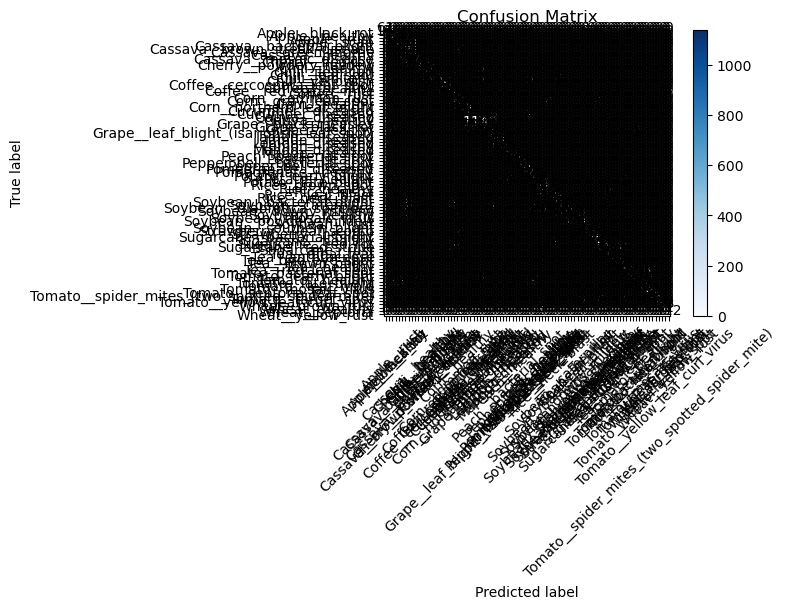

In [12]:
import numpy as np
import itertools

# Display confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt), horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()